*Goal*: 
1. find out if the dataset fits the data requirements
2. get interactions dataframe ['user_id', 'item_id', 'date'(%Y-%m), 'timetsamp']
2. get item meta dataframe ['item_id', meta_col('genre_id' or 'tag_id', etc...)]

*Ideal Data Requirements*:
* user activity is >80% of all time intervals
* month 1, user has >5 rates
* month 0, to pre-train model
* items are comparable
* timestamp
* implicit feedback
* ranking problem


*Conclusion*:

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
import pandas as pd 
import re
import numpy as np

from data_utils import getDF, getDF_n_lines, load_data
from dataset_evaluation_utils import * 

from datetime import datetime, timezone
import gzip
import json

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

# paths

In [3]:
dataset_folderpath = '../datasets/goodreads/'

dataset_name = 'Goodreads'
dump_foldername ='goodreads_dump/'

# rule: what/which_data_set/sample_version/what/
images_path, output_path, heatmaps_path, diversity_graphpath, diversity_filepath = get_folderpaths(dump_foldername)

___

# Goodreads

https://mengtingwan.github.io/data/goodreads#datasets

## column names

In [4]:
inter_columns = ['user_id', 'item_id', 'date','timestamp']
# meta_col = ''
# item_meta_columns = ['item_id', meta_col]

In [ ]:
# takes 5min on my pc
orig_df = pd.read_csv(dataset_folderpath+'goodreads_interactions.csv')
orig_df


# snipet of datasets

In [6]:
orig_df

,user_id,book_id,is_read,rating,is_reviewed
0,0,948,1,5,0
1,0,947,1,5,1
2,0,946,1,5,0
3,0,945,1,5,0
4,0,944,1,5,0
...,...,...,...,...,...
228648337,876144,24772,0,0,0
228648338,876144,23847,1,4,0
228648339,876144,23950,1,3,0
228648340,876144,374106,1,5,1


In [4]:
load_data(dataset_folderpath+'goodreads_interactions_dedup.json.gz', head=3)

[{'user_id': '8842281e1d1347389f2ab93d60773d4d',
  'book_id': '34684622',
  'review_id': 'a53868823f065a0e20fd4ae98b820674',
  'is_read': False,
  'rating': 0,
  'review_text_incomplete': '',
  'date_added': 'Tue Oct 17 09:40:11 -0700 2017',
  'date_updated': 'Tue Oct 17 09:40:12 -0700 2017',
  'read_at': '',
  'started_at': ''},
 {'user_id': '8842281e1d1347389f2ab93d60773d4d',
  'book_id': '34536488',
  'review_id': '9f08c5f991f87f3b7ae4ce779c2aac10',
  'is_read': False,
  'rating': 0,
  'review_text_incomplete': '',
  'date_added': 'Fri Oct 13 07:19:50 -0700 2017',
  'date_updated': 'Fri Oct 13 07:19:50 -0700 2017',
  'read_at': '',
  'started_at': ''},
 {'user_id': '8842281e1d1347389f2ab93d60773d4d',
  'book_id': '34017076',
  'review_id': '14da595c5b0c38b1247888f62f74a772',
  'is_read': False,
  'rating': 0,
  'review_text_incomplete': '',
  'date_added': 'Fri Oct 06 09:32:42 -0700 2017',
  'date_updated': 'Fri Oct 06 09:32:43 -0700 2017',
  'read_at': '',
  'started_at': ''},
 {'u

In [5]:
load_data(dataset_folderpath+'goodreads_book_authors.json.gz', head=3)

[{'average_rating': '3.98',
  'author_id': '604031',
  'text_reviews_count': '7',
  'name': 'Ronald J. Fields',
  'ratings_count': '49'},
 {'average_rating': '4.08',
  'author_id': '626222',
  'text_reviews_count': '28716',
  'name': 'Anita Diamant',
  'ratings_count': '546796'},
 {'average_rating': '3.92',
  'author_id': '10333',
  'text_reviews_count': '5075',
  'name': 'Barbara Hambly',
  'ratings_count': '122118'},
 {'average_rating': '3.68',
  'author_id': '9212',
  'text_reviews_count': '36262',
  'name': 'Jennifer Weiner',
  'ratings_count': '888522'}]

In [6]:
load_data(dataset_folderpath+'goodreads_book_genres_initial.json.gz', head=3)

[{'book_id': '5333265',
  'genres': {'history, historical fiction, biography': 1}},
 {'book_id': '1333909',
  'genres': {'fiction': 219, 'history, historical fiction, biography': 5}},
 {'book_id': '7327624',
  'genres': {'fantasy, paranormal': 31,
   'fiction': 8,
   'mystery, thriller, crime': 1,
   'poetry': 1}},
 {'book_id': '6066819',
  'genres': {'fiction': 555, 'romance': 23, 'mystery, thriller, crime': 10}}]

In [7]:
load_data(dataset_folderpath+'goodreads_book_series.json.gz', head=3)

[{'numbered': 'true',
  'note': '',
  'description': '',
  'title': 'Sun Wolf and Starhawk',
  'series_works_count': '9',
  'series_id': '189911',
  'primary_work_count': '3'},
 {'numbered': 'true',
  'note': '',
  'description': 'This series is also known as * Avalon : Jalinan Sihir (Bahasa Indonesia) See also the spin-off manga series \x01.',
  'title': 'Avalon: Web of Magic',
  'series_works_count': '14',
  'series_id': '151854',
  'primary_work_count': '12'},
 {'numbered': 'true',
  'note': '',
  'description': 'Plot-wise, "Crowner\'s Crusade" is a prequel to the series, but #15 in publication order.',
  'title': 'Crowner John Mystery',
  'series_works_count': '15',
  'series_id': '169353',
  'primary_work_count': '15'},
 {'numbered': 'true',
  'note': '',
  'description': '',
  'title': "Pluto's Snitch",
  'series_works_count': '3',
  'series_id': '1052227',
  'primary_work_count': '3'}]

In [8]:
load_data(dataset_folderpath+'goodreads_book_works.json.gz', head=3)

[{'books_count': '1',
  'reviews_count': '6',
  'original_publication_month': '8',
  'default_description_language_code': '',
  'text_reviews_count': '1',
  'best_book_id': '5333265',
  'original_publication_year': '1984',
  'original_title': 'W. C. Fields: A Life on Film',
  'rating_dist': '5:1|4:1|3:1|2:0|1:0|total:3',
  'default_chaptering_book_id': '',
  'original_publication_day': '',
  'original_language_id': '',
  'ratings_count': '3',
  'media_type': 'book',
  'ratings_sum': '12',
  'work_id': '5400751'},
 {'books_count': '22',
  'reviews_count': '10162',
  'original_publication_month': '',
  'default_description_language_code': '',
  'text_reviews_count': '741',
  'best_book_id': '25717',
  'original_publication_year': '2001',
  'original_title': 'Good Harbor',
  'rating_dist': '5:517|4:1787|3:2763|2:966|1:196|total:6229',
  'default_chaptering_book_id': '',
  'original_publication_day': '',
  'original_language_id': '',
  'ratings_count': '6229',
  'media_type': 'book',
  'ra

In [9]:
load_data(dataset_folderpath+'goodreads_books.json.gz', head=3)

[{'isbn': '0312853122',
  'text_reviews_count': '1',
  'series': [],
  'country_code': 'US',
  'language_code': '',
  'popular_shelves': [{'count': '3', 'name': 'to-read'},
   {'count': '1', 'name': 'p'},
   {'count': '1', 'name': 'collection'},
   {'count': '1', 'name': 'w-c-fields'},
   {'count': '1', 'name': 'biography'}],
  'asin': '',
  'is_ebook': 'false',
  'average_rating': '4.00',
  'kindle_asin': '',
  'similar_books': [],
  'description': '',
  'format': 'Paperback',
  'link': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
  'authors': [{'author_id': '604031', 'role': ''}],
  'publisher': "St. Martin's Press",
  'num_pages': '256',
  'publication_day': '1',
  'isbn13': '9780312853129',
  'publication_month': '9',
  'edition_information': '',
  'publication_year': '1984',
  'url': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
  'image_url': 'https://images.gr-assets.com/books/1310220028m/5333265.jpg',
  'book_id': '5333265',
  'ratings_count': '3',
  'w

In [10]:
load_data(dataset_folderpath+'goodreads_reviews_spoiler.json.gz', head=3)

[{'user_id': '8842281e1d1347389f2ab93d60773d4d',
  'timestamp': '2017-08-30',
  'review_sentences': [[0, 'This is a special book.'],
   [0,
    'It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind.'],
   [0,
    'This is what I love about good science fiction - it pushes your thinking about where things can go.'],
   [0,
    "It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read."],
   [0,
    'For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc.'],
   [0, 'It is a book about science, and aliens.'],
   [0,
    'The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell.'],
   [1,
    'Though when it got to folding protons into 8 dimensions I think he was just making stuff up - intere

# get interactions df

In [5]:
getDF_n_lines(dataset_folderpath+'goodreads_interactions_dedup.json.gz', head=3)
# inter_dedup = getDF(dataset_folderpath+'goodreads_interactions_dedup.json.gz') # 170min running and didn't finish

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,34684622,a53868823f065a0e20fd4ae98b820674,False,0,,Tue Oct 17 09:40:11 -0700 2017,Tue Oct 17 09:40:12 -0700 2017,,
1,8842281e1d1347389f2ab93d60773d4d,34536488,9f08c5f991f87f3b7ae4ce779c2aac10,False,0,,Fri Oct 13 07:19:50 -0700 2017,Fri Oct 13 07:19:50 -0700 2017,,
2,8842281e1d1347389f2ab93d60773d4d,34017076,14da595c5b0c38b1247888f62f74a772,False,0,,Fri Oct 06 09:32:42 -0700 2017,Fri Oct 06 09:32:43 -0700 2017,,
3,8842281e1d1347389f2ab93d60773d4d,71730,bd1a29916eb3ea1d0d45d4f7395920c5,False,0,,Tue Oct 03 23:31:03 -0700 2017,Tue Oct 03 23:39:42 -0700 2017,,


In [18]:
'''
    Stats of the 1st *head* number of lines of the goodreads_interactions_dedup file
    code inspired https://github.com/MengtingWan/goodreads/blob/master/reviews.ipynb
'''
time_format = '%a %b %d %H:%M:%S %z %Y'
head = 100000 
fn = dataset_folderpath+'goodreads_interactions_dedup.json.gz'
print('counting file:', fn)

n_lines, n_isread, n_pos_rates, n_empty_reviews, n_review_updates_spaced_min_1d, n_readat_dates = 0, 0, 0, 0, 0, 0
book_set, user_set, review_set, user_book_set = set(), set(), set(), set()
# n_lines, n_sentence, n_spoiler_review, n_spoiler_sentence = 0, 0, 0, 0
# book_set, user_set = set(), set()
print('current line: ', end='')
with gzip.open(fn) as fin:
    for l in fin:
        d = json.loads(l)

        if (head is not None) and (n_lines > head):
            break
        
        if n_lines % 1000000 == 0:
            print(n_lines, end=',')
        n_lines += 1

        n_isread += 1 if d['is_read'] else 0
        n_pos_rates += 1 if d['rating'] > 4 else 0
        n_empty_reviews +=1 if d['review_text_incomplete']=='' else 0

        delta = datetime.strptime(d['date_updated'], time_format) - datetime.strptime(d['date_added'], time_format)
        n_review_updates_spaced_min_1d += 1 if abs(delta.days) > 1 else 0

        n_readat_dates += 1 if d['read_at'] != '' else 0

        book_set.add(d['book_id'])
        user_set.add(d['user_id'])
        review_set.add(d['review_id'])
        user_book_set.add((d['user_id'], d['book_id']))

print('complete')
print('done!')
print('number of lines ',n_lines)
print('number of books flagged as read ',n_isread, n_isread/n_lines)
print('number of positive rates (5 stars) ',n_pos_rates, n_pos_rates/n_lines)
print('number of empty reviews ',n_empty_reviews, n_empty_reviews/n_lines)
print('number of reviews updated after more than 1 day ',n_review_updates_spaced_min_1d, n_review_updates_spaced_min_1d/n_lines)
print('number of values in read_at column ',n_readat_dates, n_readat_dates/n_lines)
print('number of books ',len(book_set), len(book_set)/n_lines)
print('number of users ',len(user_set), len(user_set)/n_lines)
print('number of reviews ',len(review_set), len(review_set)/n_lines)
print('number of user_alpha-book_A reviews ',len(user_book_set), len(user_book_set)/n_lines)
# print(n_lines, n_isread, n_pos_rates, n_empty_reviews, n_review_updates_spaced_min_1d, n_readat_dates, len(book_set), len(user_set), len(review_set))

counting file: ../datasets/goodreads/goodreads_interactions_dedup.json.gz
current line: 0,complete
done!
number of lines  100001
number of books flagged as read  46876 0.4687553124468755
number of positive rates (5 stars)  14056 0.14055859441405585
number of empty reviews  91709 0.9170808291917081
number of reviews updated after more than 1 day  23348 0.23347766522334776
number of values in read_at column  20742 0.20741792582074178
number of books  59158 0.5915740842591574
number of users  228 0.0022799772002279977
number of reviews  100001 1.0
number of user_alpha-book_A reviews  100001 1.0


In [6]:
inter_columns

['user_id', 'item_id', 'date', 'timestamp']

# load_interactions_to_dict

In [8]:
# pos_rates_folderpath = output_path+'pos_rates_only/'
# validate_folderpath(pos_rates_folderpath)

# time_format = '%a %b %d %H:%M:%S %z %Y'
# head = int(100000/0.14)  # 100k has 14% of positive rates, but i want all
# fn = dataset_folderpath+'goodreads_interactions_dedup.json.gz'


def load_interactions_to_dict(head:int, rating:int, save_folder:str, save_filename:str, file_foldername:str):
    '''
        Loads the positive ratings interactions of 'goodreads_interactions_dedup.json.gz' file to a dict
        Prints some stats of the filtered interactions
        
        head: int, number of lines to read
        rating: int, positive rates will be those above it
    '''

    validate_folderpath(save_folder)

    print('counting file:', file_foldername)

    time_format='%a %b %d %H:%M:%S %z %Y'
    
    n_lines, n_pos_rates = 0, 0
    book_set, user_set = set(), set()

    inter_dedup_dict = {}

    print('current line: ', end='')
    with gzip.open(file_foldername) as fin:
        for l in fin:
            d = json.loads(l)

            if (head is not None) and (n_lines > head):
                break
            
            if n_lines % 100000 == 0:
                print(n_lines, end=',')
            n_lines += 1

            # only positive ratings, 4 and 5 stars
            if d['rating'] > rating:
                n_pos_rates += 1
                
                date = datetime.strptime(d['date_added'], time_format)
                date = datetime.strptime(str(date.year)+'-'+str(date.month), '%Y-%m' )
                ts = datetime.timestamp(date)

                is_reviewed = 1 if d['review_text_incomplete']!='' else 0 

                book_set.add(d['book_id'])
                user_set.add(d['user_id'])

                inter_dedup_dict[n_lines] = [d['user_id'], d['book_id'], d['is_read'], is_reviewed, ts, date]


    joblib.dump(inter_dedup_dict, save_folder+save_filename+'_dict.joblib')

    print('complete')
    print('done!')
    print('number of lines ',n_lines)
    print('number of positive rates (>'+str(rating)+' stars) ',n_pos_rates, n_pos_rates/n_lines)
    print('number of books ',len(book_set), len(book_set)/n_lines)
    print('number of users ',len(user_set), len(user_set)/n_lines)

    return inter_dedup_dict

In [9]:
# pos_rates_folderpath = output_path+'pos_rates_only/'
# validate_folderpath(pos_rates_folderpath)

# time_format = '%a %b %d %H:%M:%S %z %Y'
# head = int(100000/0.14)  # 100k has 14% of positive rates, but i want all
# stars = 3

# fn = dataset_folderpath+'goodreads_interactions_dedup.json.gz'

# print('counting file:', fn)

# n_lines, n_pos_rates = 0, 0
# book_set, user_set = set(), set()

# inter_dedup_dict = {}

# print('current line: ', end='')
# with gzip.open(fn) as fin:
#     for l in fin:
#         d = json.loads(l)

#         if (head is not None) and (n_lines > head):
#             break
        
#         if n_lines % 100000 == 0:
#             print(n_lines, end=',')
#         n_lines += 1

#         # only positive ratings, 4 and 5 stars
#         if d['rating'] > stars:
#             n_pos_rates += 1
            
#             date = datetime.strptime(d['date_added'], time_format)
#             date = datetime.strptime(str(date.year)+'-'+str(date.month), '%Y-%m' )
#             ts = datetime.timestamp(date)

#             is_reviewed = 1 if d['review_text_incomplete']!='' else 0 

#             book_set.add(d['book_id'])
#             user_set.add(d['user_id'])

#             inter_dedup_dict[n_lines] = [d['user_id'], d['book_id'], d['is_read'], is_reviewed, ts, date]


# joblib.dump(inter_dedup_dict, pos_rates_folderpath+'inter_dedup_dict_+'+str(stars)+'stars.joblib')

# print('complete')
# print('done!')
# print('number of lines ',n_lines)
# print('number of positive rates (>'+str(stars)+' stars)',n_pos_rates, n_pos_rates/n_lines)
# print('number of books ',len(book_set), len(book_set)/n_lines)
# print('number of users ',len(user_set), len(user_set)/n_lines)

save_folder=output_path+'pos_rates_only/'
save_filename='inter_dedup_+3stars'

inter_dedup_dict  = load_interactions_to_dict(head= int(100000/0.14), # 100k has 14% of positive rates, but i want all... c:
                                                rating =  3,
                                                save_folder=save_folder, 
                                                save_filename=save_filename,
                                                file_foldername=dataset_folderpath+'goodreads_interactions_dedup.json.gz')

counting file: ../datasets/goodreads/goodreads_interactions_dedup.json.gz
current line: 0,

100000,200000,300000,400000,500000,600000,700000,complete
done!
number of lines  714286
number of positive rates (>3 stars)  227255 0.3181568727372509
number of books  94358 0.13210114715954113
number of users  1420 0.001987999204800318


# positive interactions dataframe

In [5]:
user_col = 'user_id'
item_col = 'book_id'
date_col = 'date'
inter_dedup_columns = ['user_id','book_id', 'is_read','is_reviewed', 'timestamp', 'date']

In [11]:
pos_inter = pd.DataFrame.from_dict(inter_dedup_dict, orient='index',columns=inter_dedup_columns)
pos_inter.head()

,user_id,book_id,is_read,is_reviewed,timestamp,date
15,8842281e1d1347389f2ab93d60773d4d,24375664,True,1,1.501560e+09,2017-08-01
22,8842281e1d1347389f2ab93d60773d4d,18245960,True,1,1.498882e+09,2017-07-01
24,8842281e1d1347389f2ab93d60773d4d,22078596,True,1,1.498882e+09,2017-07-01
25,8842281e1d1347389f2ab93d60773d4d,6644782,True,1,1.498882e+09,2017-07-01
69,8842281e1d1347389f2ab93d60773d4d,6480781,True,0,1.488344e+09,2017-03-01


In [12]:
pos_inter.to_csv(save_folder+save_filename+'_df.csv')

In [13]:
pos_inter.date.max()

Timestamp('2017-10-01 00:00:00')

In [14]:
pos_inter.date.min()

Timestamp('2006-08-01 00:00:00')

In [15]:
dataset_name

'Goodreads'

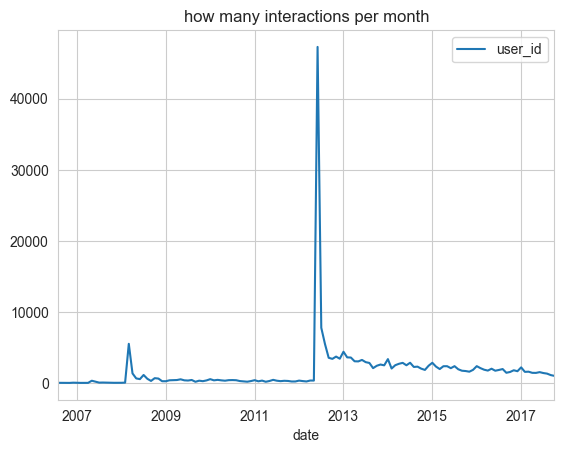

In [16]:
pos_inter[[user_col, date_col]]\
        .groupby(date_col)\
            .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

,user_id,book_id,is_read,is_reviewed,timestamp,date
216,8842281e1d1347389f2ab93d60773d4d,1969280,True,0,1.414814e+09,2014-11-01
217,8842281e1d1347389f2ab93d60773d4d,17290220,True,1,1.414814e+09,2014-11-01
219,8842281e1d1347389f2ab93d60773d4d,6882,True,0,1.412136e+09,2014-10-01
220,8842281e1d1347389f2ab93d60773d4d,6954929,True,1,1.412136e+09,2014-10-01
224,8842281e1d1347389f2ab93d60773d4d,18176747,True,1,1.412136e+09,2014-10-01


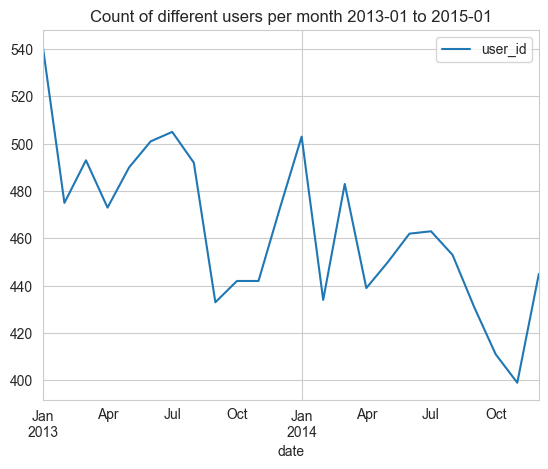

In [17]:
df_1315, _, _, _ = sample_time_period(['2013-01','2015-01'], pos_inter, col=user_col, time_col=date_col)
df_1315.head()

not enough interactions per semester (aka >10k/bucket)

In [23]:
_dict  = load_interactions_to_dict(head=int(100000/0.14)*4,
                                      rating=3,
                                      save_folder=output_path+'pos_rates_only/', 
                                      save_filename='inter_dedup_+3stars_4x714k',
                                      file_foldername=dataset_folderpath+'goodreads_interactions_dedup.json.gz')
_df = pd.DataFrame.from_dict(_dict, orient='index',columns=inter_dedup_columns)

counting file: ../datasets/goodreads/goodreads_interactions_dedup.json.gz
current line: 0,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000,1900000,2000000,2100000,2200000,2300000,2400000,2500000,2600000,2700000,2800000,complete
done!
number of lines  2857141
number of positive rates (>3 stars)  927880 0.3247582110928372
number of books  254311 0.0890089078557901
number of users  5632 0.001971201281280833


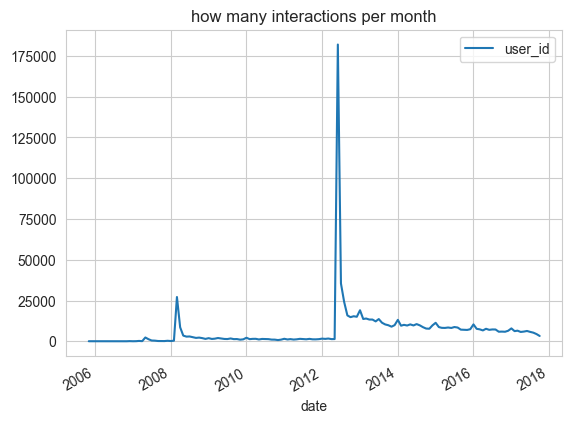

In [24]:
_df[[user_col, date_col]]\
        .groupby(date_col)\
            .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

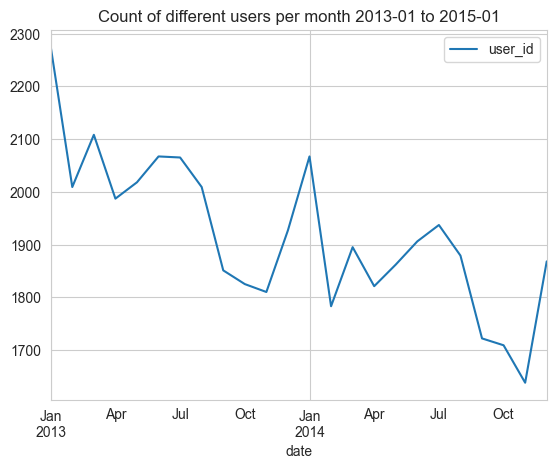

In [25]:
_, _, _, _ = sample_time_period(['2013-01','2015-01'], _df, col=user_col, time_col=date_col)

# load_interactions_within_period_to_dict

In [69]:
def load_interactions_within_period_to_dict(head, rating, period, save_folder, save_filename, file_foldername, time_format='%a %b %d %H:%M:%S %z %Y'):
    '''
        Loads the positive ratings interactions, within the given period, of 'goodreads_interactions_dedup.json.gz' file to a dict
        Prints some stats of the filtered interactions
        
        head: int, number of lines to read
        rating: int, positive rates will be those above it
    '''

    validate_folderpath(save_folder)

    print('counting file:', file_foldername)

    # start_year, end_year = period
    time_period = [(period[0], '%Y-%m'), (period[1], '%Y-%m')]
    start_ym, end_ym = datetime.strptime(*time_period[0]), datetime.strptime(*time_period[1])

    n_lines, n_pos_rates = 0, 0
    book_set, user_set = set(), set()

    inter_dedup_dict = {}

    print('current line: ', end='')
    with gzip.open(file_foldername) as fin:
        for l in fin:
            d = json.loads(l)

            if (head is not None) and (n_lines > head):
                break
            
            if n_lines % 100000 == 0:
                print(n_lines, end=',')
            n_lines += 1
            
            date = datetime.strptime(d['date_added'], time_format)
            year_month = datetime.strptime( str(date.year)+'-'+str(date.month), '%Y-%m' )
            # if (date.year >= start_year) & (date.year <= end_year): 
            if start_ym <= year_month <= end_ym:
                # only positive ratings, 4 and 5 stars
                if d['rating'] > rating:
                    n_pos_rates += 1
                    
                    # date = datetime.strptime(d['date_added'], time_format)
                    date = datetime.strptime(str(date.year)+'-'+str(date.month), '%Y-%m' )
                    ts = datetime.timestamp(date)

                    is_reviewed = 1 if d['review_text_incomplete']!='' else 0 

                    book_set.add(d['book_id'])
                    user_set.add(d['user_id'])

                    inter_dedup_dict[n_lines] = [d['user_id'], d['book_id'], d['is_read'], is_reviewed, ts, date]


    joblib.dump(inter_dedup_dict, save_folder+save_filename+'_dict.joblib')

    print('complete')
    print('done!')
    print('number of lines ',n_lines)
    print('number of positive rates (>'+str(rating)+' stars) ',n_pos_rates, n_pos_rates/n_lines)
    print('number of books ',len(book_set), len(book_set)/n_lines)
    print('number of users ',len(user_set), len(user_set)/n_lines)

    return inter_dedup_dict

In [31]:
int(100000/0.14)*4

2857140

In [11]:
inter_dedup_columns

['user_id', 'book_id', 'is_read', 'is_reviewed', 'timestamp', 'date']

counting file: ../datasets/goodreads/goodreads_interactions_dedup.json.gz
current line: 0,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000,1900000,2000000,2100000,2200000,2300000,2400000,2500000,2600000,2700000,2800000,complete
done!
number of lines  2857141
number of positive rates (>3 stars)  398129 0.13934524057440636
number of books  132352 0.04632323011009957
number of users  5204 0.0018214011839107695


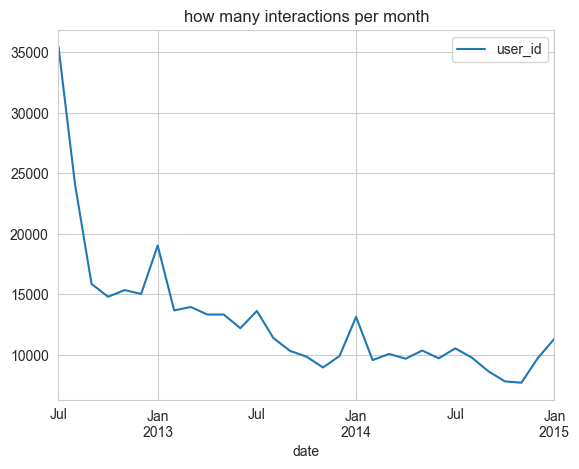

In [70]:
period=['2012-07', '2015-01']
sample = 'sample_'+str(period[0])+'_until_'+str(period[1])
save_folder = output_path+'pos_rates_only/'+sample+'/'
filename = 'inter_dedup_coldstart_3stars_4x714k'

interd_2  = load_interactions_within_period_to_dict(head=int(100000/0.14)*4,
                                      rating=3,
                                      period=period,# ['2012-06', '2015-01'[ 
                                      save_folder=save_folder, 
                                      save_filename=filename,
                                      file_foldername=dataset_folderpath+'goodreads_interactions_dedup.json.gz')
pos_inter_2 = pd.DataFrame.from_dict(interd_2, orient='index',columns=inter_dedup_columns)
pos_inter_2[[user_col, date_col]]\
        .groupby(date_col)\
            .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

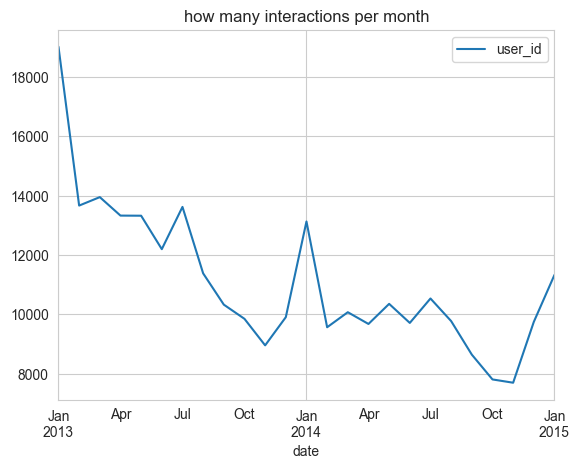

In [71]:
ym = datetime.strptime('2012-12', '%Y-%m' )
pos_inter_2.loc[pos_inter_2[date_col]>ym,[user_col, date_col]]\
        .groupby(date_col)\
            .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

In [72]:
print(save_folder)
print(filename)

output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/
inter_dedup_coldstart_3stars_4x714k


In [73]:
pos_inter_2.to_csv(save_folder+filename+'_df.csv')

## stats on the sampled dataframe

In [74]:
pos_inter_2.head()

,user_id,book_id,is_read,is_reviewed,timestamp,date
205,8842281e1d1347389f2ab93d60773d4d,25019,True,0,1.420088e+09,2015-01-01
216,8842281e1d1347389f2ab93d60773d4d,1969280,True,0,1.414814e+09,2014-11-01
217,8842281e1d1347389f2ab93d60773d4d,17290220,True,1,1.414814e+09,2014-11-01
219,8842281e1d1347389f2ab93d60773d4d,6882,True,0,1.412136e+09,2014-10-01
220,8842281e1d1347389f2ab93d60773d4d,6954929,True,1,1.412136e+09,2014-10-01


In [75]:
pos_inter_2['is_read'].value_counts() # Great! ^o^

True    398129
Name: is_read, dtype: int64

In [76]:
pos_inter_2['is_reviewed'].value_counts() # written wise

0    329294
1     68835
Name: is_reviewed, dtype: int64

In [77]:
pos_inter_2.drop(columns=['is_read','is_reviewed']).to_csv(save_folder+filename+'_interactions_df.csv')

# get_interactions_info

In [78]:
period

['2012-07', '2015-01']

In [79]:
# bc the 1st semester will be for cold start purposes, the time period sample is starting on 2013
# (the frequent users are calculated from after 2013 and only those users' interactions will go to holdouts)
# the frequent users
# posint_1314, _, _, _ = sample_time_period(['2013-01','2015-01'], pos_inter_2, col=user_col, time_col=date_col)

user_presence_df, user_month_interactions, \
    trimestres, user_trimestre_interactions, \
        semesters, user_semester_interactions = get_interactions_info(pos_inter_2, user_col, quarter_info=True, semester_info=True)

0.0 %
25.0 %
50.0 %
75.0 %


In [85]:
user_presence_df

,UserID,month_%,trimestre_%,semestre_%
0,f18e9a17737c79e96b197362451c1610,1.000000,1.000000,1.000000
1,037c382333b7084ccee4cdec7401de90,1.000000,1.000000,1.000000
2,7882af1eb95acebce28113dbeafb63d1,1.000000,1.000000,1.000000
3,d9cb15785eaea3f8770987d8b73d7d22,1.000000,1.000000,1.000000
4,2eb0f13eafc83e80254e51b983b8d83c,1.000000,1.000000,1.000000
...,...,...,...,...
5199,19d309921a75b70d24cac8345b2f834d,0.032258,0.090909,0.166667
5200,1c4ef8dba9639719deb6b5868dd895dd,0.032258,0.090909,0.166667
5201,ce14996da60ea145f14e1ac77b54a4d5,0.032258,0.090909,0.166667
5202,6beed6d8590598fc62cdafb12ddc5847,0.032258,0.090909,0.166667


In [87]:
semesters

[(Timestamp('2012-07-01 00:00:00'),
  Timestamp('2012-12-31 00:00:00', freq='6M')),
 (Timestamp('2013-01-01 00:00:00'),
  Timestamp('2013-06-30 00:00:00', freq='6M')),
 (Timestamp('2013-07-01 00:00:00'),
  Timestamp('2013-12-31 00:00:00', freq='6M')),
 (Timestamp('2014-01-01 00:00:00'),
  Timestamp('2014-06-30 00:00:00', freq='6M')),
 (Timestamp('2014-07-01 00:00:00'),
  Timestamp('2014-12-31 00:00:00', freq='6M'))]

In [81]:
print(save_folder)
print(sample)
print(filename)

output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/
sample_2012-07_until_2015-01
inter_dedup_coldstart_3stars_4x714k


In [82]:
joblib.dump(user_presence_df, save_folder+filename+'_user_presence_df.joblib')
joblib.dump(user_month_interactions, save_folder+filename+'_user_month_interactions.joblib')
joblib.dump(trimestres, save_folder+filename+'_trimestres.joblib')
joblib.dump(user_trimestre_interactions, save_folder+filename+'_user_trimestre_interactions.joblib')
joblib.dump(semesters, save_folder+filename+'_semesters.joblib')
joblib.dump(user_semester_interactions, save_folder+filename+'_user_semester_interactions.joblib')

thr=0.8


frequent_users = get_frequent_users(user_presence_df, frequency_threshold=thr)
joblib.dump(frequent_users, save_folder+filename+'_frequent_users_'+str(thr)+'.joblib') # has all 3 in one file

# frequent_users_month,\
#     frequent_users_trimester,\
#         frequent_users_semester = get_frequent_users(user_presence_df, frequency_threshold=thr)
# joblib.dump(frequent_users_month, save_folder+filename+'_frequent_users_month'+str(thr)+'.joblib')
# joblib.dump(frequent_users_trimester, save_folder+filename+'_frequent_users_trimester'+str(thr)+'.joblib')
# joblib.dump(frequent_users_semester, save_folder+filename+'_frequent_users_semester'+str(thr)+'.joblib')

572 users of 5204 (10.992%) occurr in 80.0% or more months.
1628 users of 5204 (31.284%) occurr in 80.0% or more quarters.
2426 users of 5204 (46.618%) occurr in 80.0% or more semesters.


['output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/inter_dedup_coldstart_3stars_4x714k_frequent_users0.8.joblib']

In [83]:
len(frequent_users)

3

In [90]:
frequent_users

(array(['f18e9a17737c79e96b197362451c1610',
        '037c382333b7084ccee4cdec7401de90',
        '7882af1eb95acebce28113dbeafb63d1',
        'd9cb15785eaea3f8770987d8b73d7d22',
        '2eb0f13eafc83e80254e51b983b8d83c',
        'b6eb81c5d09dfe232397ced641e67993',
        'd2f4a240821246a08d1a73eb08271170',
        '8d05420db5a5ef6d521d3fda5ec5ba81',
        '01765a61b489e69584d0343a574c1246',
        'ddb35fd0fbb0b71f2fa56d1e26633e8f',
        '2138f2f7e5d766220af5a36e7dc0c9e1',
        '86de4e93982d924f47f3b1371a2536ad',
        '55475556ab32863fed66cb94a404af71',
        'ddc44923909c38b4d149a38431105943',
        '9adf5413d7cc99ce8c7723b4f1b1e4aa',
        '2072483ab40c0d43a83f8bcede5f92c7',
        'ec75c6194f8e672df6456e493781907e',
        '7fbfe2412623e7376e5d9c68cae96ed0',
        'f803057b1dc5c173e51391127a565c3f',
        'd36a167d9d05249418d8d7d821cdc3ce',
        'ab2fadb5c7bbe55c80406d2b3692e969',
        'b56a79469299b9dd55288709dfc9c46c',
        '780b52a9ec057a458031353

In [84]:
user_semester_interactions

,0,1,2,3,4,5
49dbf2b3c5585991146872704f10c602,5.0,3.0,3.0,1.0,3.0,0.0
9322755ba828df4ba96c7028658b49a1,3.0,4.0,0.0,5.0,6.0,1.0
28ad10b46d02b7279804b5e55299080f,4.0,1.0,1.0,0.0,0.0,0.0
e45112e00e00ccb396068b5a0c6d8c25,2.0,3.0,1.0,3.0,3.0,1.0
934d08f384abac141428232e8655e0b8,2.0,2.0,4.0,1.0,0.0,0.0
...,...,...,...,...,...,...
f3222d936d510c03527d8f24625e1f4f,0.0,0.0,0.0,0.0,0.0,1.0
f5fc13bdff1cfe3186f50526ffd593ee,0.0,0.0,0.0,0.0,0.0,1.0
68f159ecdce0c8e26290ba89dafcede2,0.0,0.0,0.0,0.0,0.0,1.0
3b0480edddfb72236c9626f7a7499a5a,0.0,0.0,0.0,0.0,0.0,1.0


In [88]:
semesters_idx=[2,3,4,5]
n_semester_thr=3
frequent_users_1314_semester_interactions = get_semester_info_with_user_thresh(print_timeperiod='2013 and 2014',
                                                                                  usi=user_semester_interactions,
                                                                                  semesters_idx=semesters_idx,
                                                                                  n_semester_thr=n_semester_thr)

frequent_users_1314_semester_interactions

2862 users of 5204 (54.99615680245965%) are in 75.0% or more semesters in 2013 and 2014 (30790.0 interactions)

Number of interactions per semester in 2013 and 2014:
 2    9477.0
3    9922.0
4    9557.0
5    1834.0
dtype: float64


,2,3,4,5
49dbf2b3c5585991146872704f10c602,3.0,1.0,3.0,0.0
9322755ba828df4ba96c7028658b49a1,0.0,5.0,6.0,1.0
e45112e00e00ccb396068b5a0c6d8c25,1.0,3.0,3.0,1.0
09807115450c9c2b7de093eaa8476dc7,3.0,2.0,3.0,1.0
93cabda004a7315ac9d07647ab48d8e2,1.0,3.0,2.0,1.0
...,...,...,...,...
21b148ee0c488b3703478a2b062947f5,0.0,2.0,3.0,1.0
8401be743b27ef00a231f21167e4f369,0.0,2.0,6.0,1.0
60a8c28dde7376affdea310870700d24,0.0,2.0,6.0,1.0
6d3eddbe0cdc3c74442232a7e2f7293e,0.0,1.0,6.0,1.0


looks good!

In [89]:
joblib.dump(frequent_users_1314_semester_interactions, save_folder+filename+'_fu_'+str(n_semester_thr/len(semesters_idx))+'_user_semester_interactions.joblib')

['output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/inter_dedup_coldstart_3stars_4x714k_fu_0.75_user_semester_interactions.joblib']

# get all genres

___
## proof code works

In [ ]:
# _ = pd.json_normalize(load_data(dataset_folderpath+'goodreads_book_genres_initial.json.gz', head=1000))
# _

In [ ]:
# _.columns

In [ ]:
# 'genres.history, historical fiction, biography'[len('genres.'):].split(', ')

In [ ]:
# _list = [c[len('genres.'):].split(', ') for c in _.columns[1:]]
# import itertools
# merged = list(itertools.chain(*_list))
# merged

In [ ]:
# [c[len('genres.'):] for c in _.columns[1:]]

end of code proof
___

# book genres

In [93]:
book_genres = pd.json_normalize(load_data(dataset_folderpath+'goodreads_book_genres_initial.json.gz', head=None))
book_genres

,book_id,"genres.history, historical fiction, biography",genres.fiction,"genres.fantasy, paranormal","genres.mystery, thriller, crime",genres.poetry,genres.romance,genres.non-fiction,genres.children,genres.young-adult,"genres.comics, graphic"
0,5333265,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1333909,5.0,219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7327624,NaN,8.0,31.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,6066819,NaN,555.0,NaN,10.0,NaN,23.0,NaN,NaN,NaN,NaN
4,287140,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2360650,3084038,7.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
2360651,26168430,NaN,1.0,NaN,4.0,NaN,NaN,NaN,1.0,NaN,NaN
2360652,2342551,NaN,NaN,NaN,NaN,14.0,NaN,1.0,7.0,1.0,NaN
2360653,22017381,NaN,NaN,NaN,2.0,NaN,13.0,NaN,NaN,NaN,NaN


In [94]:
item_meta_list = [c[len('genres.'):] for c in book_genres.columns[1:]]
item_meta_list

['history, historical fiction, biography',
 'fiction',
 'fantasy, paranormal',
 'mystery, thriller, crime',
 'poetry',
 'romance',
 'non-fiction',
 'children',
 'young-adult',
 'comics, graphic']

In [133]:
print(output_path)
print(save_folder)

output/goodreads_dump/
output/goodreads_dump/pos_rates_only/sample_2012-07_until_2015-01/


In [100]:
len(item_meta_list)

10

In [134]:
joblib.dump(item_meta_list, output_path+'item_meta_list.joblib')

['output/goodreads_dump/item_meta_list.joblib']

In [101]:
book_genres_clean = book_genres.replace(to_replace=np.NaN, value=0)
book_genres_clean

,book_id,"genres.history, historical fiction, biography",genres.fiction,"genres.fantasy, paranormal","genres.mystery, thriller, crime",genres.poetry,genres.romance,genres.non-fiction,genres.children,genres.young-adult,"genres.comics, graphic"
0,5333265,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1333909,5.0,219.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7327624,0.0,8.0,31.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,6066819,0.0,555.0,0.0,10.0,0.0,23.0,0.0,0.0,0.0,0.0
4,287140,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2360650,3084038,7.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
2360651,26168430,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0
2360652,2342551,0.0,0.0,0.0,0.0,14.0,0.0,1.0,7.0,1.0,0.0
2360653,22017381,0.0,0.0,0.0,2.0,0.0,13.0,0.0,0.0,0.0,0.0


In [136]:
genre_count = book_genres.drop(columns=['book_id']).count(axis=1)
book_genres_clean['genre_count'] = genre_count

In [137]:
book_genres_clean.columns = ['book_id'] + item_meta_list + ['genre_count']
book_genres_clean

,book_id,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic",genre_count
0,5333265,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1333909,5.0,219.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,7327624,0.0,8.0,31.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4
3,6066819,0.0,555.0,0.0,10.0,0.0,23.0,0.0,0.0,0.0,0.0,3
4,287140,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2360650,3084038,7.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2
2360651,26168430,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,3
2360652,2342551,0.0,0.0,0.0,0.0,14.0,0.0,1.0,7.0,1.0,0.0,4
2360653,22017381,0.0,0.0,0.0,2.0,0.0,13.0,0.0,0.0,0.0,0.0,2


In [157]:
book_genres_clean['book_id'].nunique()

2360655

## save to csv

In [138]:
book_genres_clean.to_csv(output_path+'item_meta_df.csv')

# one column book genres

In [145]:
book_genres_onecol = getDF(dataset_folderpath+'goodreads_book_genres_initial.json.gz')
book_genres_onecol['genres_list'] = book_genres_onecol['genres'].apply(lambda x: list(x.keys()))
book_genres_onecol

,book_id,genres,genres_list
0,5333265,"{'history, historical fiction, biography': 1}","[history, historical fiction, biography]"
1,1333909,"{'fiction': 219, 'history, historical fiction,...","[fiction, history, historical fiction, biography]"
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys...","[fantasy, paranormal, fiction, mystery, thrill..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri...","[fiction, romance, mystery, thriller, crime]"
4,287140,{'non-fiction': 3},[non-fiction]
...,...,...,...
2360650,3084038,"{'non-fiction': 5, 'history, historical fictio...","[non-fiction, history, historical fiction, bio..."
2360651,26168430,"{'mystery, thriller, crime': 4, 'children': 1,...","[mystery, thriller, crime, children, fiction]"
2360652,2342551,"{'poetry': 14, 'children': 7, 'young-adult': 1...","[poetry, children, young-adult, non-fiction]"
2360653,22017381,"{'romance': 13, 'mystery, thriller, crime': 2}","[romance, mystery, thriller, crime]"


In [146]:
book_genres_onecol_clean = book_genres_onecol[['book_id','genres_list']].explode('genres_list')
book_genres_onecol_clean

,book_id,genres_list
0,5333265,"history, historical fiction, biography"
1,1333909,fiction
1,1333909,"history, historical fiction, biography"
2,7327624,"fantasy, paranormal"
2,7327624,fiction
...,...,...
2360652,2342551,non-fiction
2360653,22017381,romance
2360653,22017381,"mystery, thriller, crime"
2360654,11419866,romance


In [148]:
book_genres_onecol_clean = pd.merge(book_genres_onecol_clean, book_genres_clean[['book_id', 'genre_count']])
book_genres_onecol_clean

,book_id,genres_list,genre_count
0,5333265,"history, historical fiction, biography",1
1,1333909,fiction,2
2,1333909,"history, historical fiction, biography",2
3,7327624,"fantasy, paranormal",4
4,7327624,fiction,4
...,...,...,...
5452050,2342551,non-fiction,4
5452051,22017381,romance,2
5452052,22017381,"mystery, thriller, crime",2
5452053,11419866,romance,2


## save to csv

In [149]:
book_genres_onecol_clean.to_csv(output_path+'item_meta_onecol_df.csv')

In [156]:
print('how many books have x amount of genres:\n', book_genres_clean['genre_count'].value_counts()/book_genres_clean['book_id'].nunique())#.value_counts()

how many books have x amount of genres:
 2     0.242304
3     0.198353
1     0.193554
0     0.173474
4     0.119385
5     0.054974
6     0.015417
7     0.002388
8     0.000138
9     0.000009
10    0.000005
Name: genre_count, dtype: float64


17% does not have any genres

In [154]:
book_genres_clean.loc[book_genres_clean['genre_count']==10,:]

,book_id,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic",genre_count
2887,20622475,22.0,31.0,2.0,2.0,35.0,20.0,1.0,24.0,4.0,2.0,10
797604,6622799,22.0,31.0,2.0,2.0,35.0,20.0,1.0,24.0,4.0,2.0,10
815502,116387,22.0,31.0,2.0,2.0,35.0,20.0,1.0,24.0,4.0,2.0,10
815504,116381,22.0,31.0,2.0,2.0,35.0,20.0,1.0,24.0,4.0,2.0,10
1386596,11639155,22.0,31.0,2.0,2.0,35.0,20.0,1.0,24.0,4.0,2.0,10
1403311,5922338,22.0,31.0,2.0,2.0,35.0,20.0,1.0,24.0,4.0,2.0,10
1414828,1421685,22.0,31.0,2.0,2.0,35.0,20.0,1.0,24.0,4.0,2.0,10
1980006,7989499,24.0,45.0,19.0,2.0,2.0,2.0,2.0,6.0,30.0,346.0,10
2011168,7989498,24.0,45.0,19.0,2.0,2.0,2.0,2.0,6.0,30.0,346.0,10
2211875,2199452,22.0,31.0,2.0,2.0,35.0,20.0,1.0,24.0,4.0,2.0,10


In [ ]:
#incompatible_genres = [('fiction', 'non-fiction')] ? 
# if someone labeled it as biography, could have also labled it as non-fiction, 
# but in the same train of thought, if someone labled it historical fiction, then could also have labled it as fiction

In [164]:
pd.qcut(book_genres_clean['genre_count'], 4, retbins=True, labels=False)

(0          0
 1          1
 2          3
 3          2
 4          0
           ..
 2360650    1
 2360651    2
 2360652    3
 2360653    1
 2360654    1
 Name: genre_count, Length: 2360655, dtype: int64,
 array([ 0.,  1.,  2.,  3., 10.]))